# atmaCup#10 - 美術作品の評価予測

## Import Libraries

In [3]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error as MSE, mean_squared_log_error as MSLE

import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib_venn import venn2

import os
from typing import List, Tuple, Any
from pathlib import Path
from tqdm import tqdm
from contextlib import contextmanager
from time import time

## Util Functions

In [4]:
is_google_drive = False

if is_google_drive:
    def input_dir():
        return Path("/content/drive/MyDrive/Python/Competition/atmaCup10/input")

    def output_dir():
        return Path("/content/drive/MyDrive/Python/Competition/atmaCup10/output")
else:
    def input_dir():
        return Path("input")

    def output_dir():
        return Path("output")

In [5]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

## Load Data

### art object

In [6]:
train_df = pd.read_csv(os.path.join(input_dir() / "train.csv"))
test_df = pd.read_csv(os.path.join(input_dir() / "test.csv"))
print(train_df.shape, test_df.shape)

(12026, 19) (12008, 18)


In [7]:
train_df.head().T

,0,1,2,3,4
object_id,0011d6be41612ec9eae3,0012765f7a97ccc3e9e9,0017be8caa87206532cb,00181d86ff1a7b95864e,001c52ae28ec106d9cd5
art_series_id,93c092ba70beab248f31,95c14fb11c54281ad7e0,4c406890d208fe01f8fb,fa0891535500a4973db2,8065ed5063c5887e677d
title,The Avenue of Birches,Struik in bloei,Portret van een vrouw,A St Bernard Dog,Woelige zee met zeilschepen
description,NaN,NaN,"Portret van eenvrouw, zittend naast een tafel.","Een sint-bernardshond, staand in een landschap...",Woelige zee met zeilschepen.
long_title,"The Avenue of Birches, Jan Hackaert, 1660 - 1685","Struik in bloei, Richard Tepe (attributed to),...","Portret van een vrouw, Tresling & Comp., 1860 ...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...","Woelige zee met zeilschepen, anonymous, 1825 -..."
principal_maker,Jan Hackaert,Richard Tepe,Tresling & Comp.,Bernard te Gempt,anonymous
principal_or_first_maker,Jan Hackaert,Richard Tepe,Tresling & Comp.,Bernard te Gempt,anonymous
sub_title,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,h 165mm × w 223mm,h 87mm × w 56mm,h 179cm × w 248cm × t 4cm,h 13cm × w 17.5cm × d 0.7cm
copyright_holder,NaN,erven Richard Tepe,NaN,NaN,NaN
more_title,The Avenue of Birches,Struik in bloei,Portret van een vrouw,A St Bernard Dog,Woelige zee met zeilschepen


os.makedirs(output_dir() / "profile", exist_ok=True)

report = ProfileReport(train_df)
report.to_file(os.path.join(output_dir() / 'profile/train_report.html'))

### Palette

In [8]:
palette_df = pd.read_csv(os.path.join(input_dir() / "palette.csv"))

In [9]:
merge_df = pd.DataFrame({'object_id':palette_df.object_id.unique()})

In [10]:
merge_df = merge_df.merge(palette_df.groupby('object_id')[['color_r', 'color_g', 'color_b']] \
                           .mean().add_prefix('mean_'), on='object_id')

In [11]:
idxmax = palette_df.groupby('object_id')['ratio'].idxmax()
palette_df = palette_df[palette_df.index.isin(idxmax)].drop(columns=['ratio'])

In [12]:
merge_df = merge_df.merge(palette_df, on='object_id')

In [13]:
train_df = train_df.merge(merge_df, how='left', on='object_id')

assert len(train_df) == 12_026, len(train_df)

In [14]:
test_df = test_df.merge(merge_df, how='left', on='object_id')

assert len(test_df) == 12_008, len(test_df)

### Material

In [15]:
material_df = pd.read_csv(os.path.join(input_dir() / "material.csv"))

In [16]:
vc = material_df['name'].value_counts()
material_df['CE_name'] = material_df['name'].map(vc)

idxmax = material_df.groupby('object_id')['CE_name'].idxmax()
material_df = material_df[material_df.index.isin(idxmax)].drop(columns=['CE_name'])

material_df.columns = ['object_id', 'material_name']

In [17]:
train_df = train_df.merge(material_df, how='left', on='object_id')

assert len(train_df) == 12_026, len(train_df)

In [18]:
test_df = test_df.merge(material_df, how='left', on='object_id')

assert len(test_df) == 12_008, len(test_df)

### Historical Person

In [19]:
historical_person_df = pd.read_csv(os.path.join(input_dir() / "historical_person.csv"))

In [20]:
vc = historical_person_df['name'].value_counts()
historical_person_df['CE_name'] = historical_person_df['name'].map(vc)

idxmax = historical_person_df.groupby('object_id')['CE_name'].idxmax()
historical_person_df = historical_person_df[historical_person_df.index.isin(idxmax)].drop(columns=['CE_name'])

historical_person_df.columns = ['object_id', 'person_name']

In [21]:
train_df = train_df.merge(historical_person_df, how='left', on='object_id')

assert len(train_df) == 12_026, len(train_df)

In [22]:
test_df = test_df.merge(historical_person_df, how='left', on='object_id')

assert len(test_df) == 12_008, len(test_df)

### Object Colletion

In [23]:
object_collection_df = pd.read_csv(os.path.join(input_dir() / "object_collection.csv"))

In [24]:
vc = object_collection_df['name'].value_counts()
object_collection_df['CE_name'] = object_collection_df['name'].map(vc)

idxmax = object_collection_df.groupby('object_id')['CE_name'].idxmax()
object_collection_df = object_collection_df[object_collection_df.index.isin(idxmax)].drop(columns=['CE_name'])

object_collection_df.columns = ['object_id', 'collection_name']

In [25]:
train_df = train_df.merge(object_collection_df, how='left', on='object_id')

assert len(train_df) == 12_026, len(train_df)

In [26]:
test_df = test_df.merge(object_collection_df, how='left', on='object_id')

assert len(test_df) == 12_008, len(test_df)

### Production Place

In [27]:
production_place_df = pd.read_csv(os.path.join(input_dir() / "production_place.csv"))

In [28]:
vc = production_place_df['name'].value_counts()
production_place_df['CE_name'] = production_place_df['name'].map(vc)

idxmax = production_place_df.groupby('object_id')['CE_name'].idxmax()
production_place_df = production_place_df[production_place_df.index.isin(idxmax)].drop(columns=['CE_name'])

production_place_df.columns = ['object_id', 'place_name']

In [29]:
train_df = train_df.merge(production_place_df, how='left', on='object_id')

assert len(train_df) == 12_026, len(train_df)

In [30]:
test_df = test_df.merge(production_place_df, how='left', on='object_id')

assert len(test_df) == 12_008, len(test_df)

### Technique

In [31]:
technique_df = pd.read_csv(os.path.join(input_dir() / "technique.csv"))

In [32]:
vc = technique_df['name'].value_counts()
technique_df['CE_name'] = technique_df['name'].map(vc)

idxmax = technique_df.groupby('object_id')['CE_name'].idxmax()
technique_df = technique_df[technique_df.index.isin(idxmax)].drop(columns=['CE_name'])

technique_df.columns = ['object_id', 'technique_name']

In [33]:
train_df = train_df.merge(technique_df, how='left', on='object_id')

assert len(train_df) == 12_026, len(train_df)

In [34]:
test_df = test_df.merge(technique_df, how='left', on='object_id')

assert len(test_df) == 12_008, len(test_df)

### Maker

In [35]:
maker_df = pd.read_csv(os.path.join(input_dir() / "maker.csv"))

In [36]:
maker_df.columns

Index(['name', 'place_of_birth', 'date_of_birth', 'date_of_death',
       'place_of_death', 'nationality'],
      dtype='object')

In [37]:
maker_df['year_of_birth'] = maker_df['date_of_birth'].apply(lambda x: x[:4] if not pd.isna(x) else x)
maker_df['year_of_death'] = maker_df['date_of_death'].apply(lambda x: x[:4] if not pd.isna(x) else x)

maker_df['period_of_birth'] = maker_df['date_of_birth'].apply(lambda x: x[:2] if not pd.isna(x) else x)
maker_df['period_of_death'] = maker_df['date_of_death'].apply(lambda x: x[:2] if not pd.isna(x) else x)

In [38]:
train_df = train_df.merge(maker_df, how='left', left_on='principal_maker', right_on='name')

In [39]:
test_df = test_df.merge(maker_df, how='left', left_on='principal_maker', right_on='name')

In [40]:
whole_df = pd.concat([train_df.drop(columns=['likes']).reset_index(), 
                      test_df.reset_index()], axis=0)

## Feature Engineering

In [41]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        return NotImplementedError()

### Numerical Features

In [42]:
def create_numerical_features(input_df):
    use_cols = [
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'year_of_birth',
        'year_of_death',
        'period_of_birth',
        'period_of_death',
        'color_r',
        'color_g',
        'color_b',
        'mean_color_r',
        'mean_color_g',
        'mean_color_b'
    ]
    
    output_df = input_df[use_cols].copy()
    output_df['dating_presenting_date'] = output_df['dating_year_late'] - output_df['dating_year_early']
    output_df['maker_life_time'] = output_df['year_of_death'].astype(float) - output_df['year_of_birth'].astype(float)
    
    return output_df

### String Length Feature

In [43]:
class stringLengthBlock(BaseBlock):
    def __init__(self, col:str):
        self.col = col
        
    def transform(self, input_df):
        output_df = pd.DataFrame()
        col = self.col
        
        output_df[col] = input_df[col].str.len()
        
        return output_df.add_prefix('StringLength_')

### Aggregation Block

In [44]:
class AggregationBlock(BaseBlock):
    def __init__(self, table_name:str):
        self.table_name = table_name
    
    def fit(self, input_df):
        _df = pd.read_csv(os.path.join(input_dir() / f"{self.table_name}.csv"))
        
        vc = _df['name'].value_counts()
        _df['CE_name'] = _df['name'].map(vc)
        
        self.agg_df = _df.groupby('object_id')['CE_name'].agg({'max', 'min', 'mean', 'std'})
        
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = input_df[['object_id']].merge(self.agg_df, 
                                                  how='left', 
                                                  on='object_id').drop(columns=['object_id'])
        
        return output_df.add_prefix(f'{self.table_name}_')

### Count Encoding

In [45]:
class CountEncoding(BaseBlock):
    def __init__(self, col:str, base_df):
        self.col = col
        self.base_df = base_df
        
    def transform(self, input_df):
        output_df = pd.DataFrame()
        col = self.col

        vc = self.base_df[col].value_counts()
        output_df[col] = input_df[col].map(vc)
        
        return output_df.add_prefix(f"CE_")

### Target Encoding

In [46]:
class TargetEncoding(BaseBlock):
    def __init__(self, col:str, target_col:str):
        self.col = col
        self.target_col = target_col
        
    def fit(self, input_df):
        _df = input_df.groupby(self.col)[self.target_col].mean()
        self.meta_df = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = pd.merge(input_df[self.col], self.meta_df, how='left', on=self.col).drop(columns=[self.col])
        return output_df.add_prefix(f"TE@{self.col}=")

### Tfidf Block

In [48]:
import texthero as hero
import nltk

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [85]:
def text_normalization(text):

    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, input_df):
        """tdidfを計算するための全体集合を返す. 
        デフォルトでは fit でわたされた dataframe を使うが, もっと別のデータを使うのも考えられる."""
        return input_df

    def fit(self, input_df, y=None):
        master_df = self.get_master(input_df)
        text = self.preprocess(input_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10_000)),
            ('svd', TruncatedSVD(n_components=50)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

### Size Extraction Block

In [91]:
class SizeExtractionBlock(BaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame()
        
        for axis in ['h', 'w', 't', 'd']:
            column_name = f"size_{axis}"
            size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis))
            size_info = size_info.rename(columns={0:column_name, 1:'unit'})
            size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float)
            size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit']=='cm' else row[column_name], axis=1)
            output_df[column_name] = size_info[column_name]
            
        return output_df

### One-hot Encoding

In [53]:
class OneHotEncoding(BaseBlock):
    def __init__(self, col:str, threshold:int=40):
        self.col = col
        self.threshold = threshold
        
    def fit(self, input_df):
        vc = input_df[self.col].dropna().value_counts()
        cats = vc[vc > self.threshold].index
        self.cats = cats
        return self.transform(input_df)
    
    def transform(self, input_df):
        x = pd.Categorical(input_df[self.col], categories=self.cats)
        output_df = pd.get_dummies(x, dummy_na=False)
        output_df.columns = output_df.columns.tolist()
        
        return output_df.add_prefix(f'OH@{self.col}=')

### Get Train Feature Data

In [54]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12026 entries, 0 to 12025
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   object_id                 12026 non-null  object 
 1   art_series_id             12026 non-null  object 
 2   title                     12026 non-null  object 
 3   description               8506 non-null   object 
 4   long_title                12026 non-null  object 
 5   principal_maker           12026 non-null  object 
 6   principal_or_first_maker  12025 non-null  object 
 7   sub_title                 11992 non-null  object 
 8   copyright_holder          713 non-null    object 
 9   more_title                11891 non-null  object 
 10  acquisition_method        11830 non-null  object 
 11  acquisition_date          11009 non-null  object 
 12  acquisition_credit_line   3525 non-null   object 
 13  dating_presenting_date    12016 non-null  object 
 14  dating

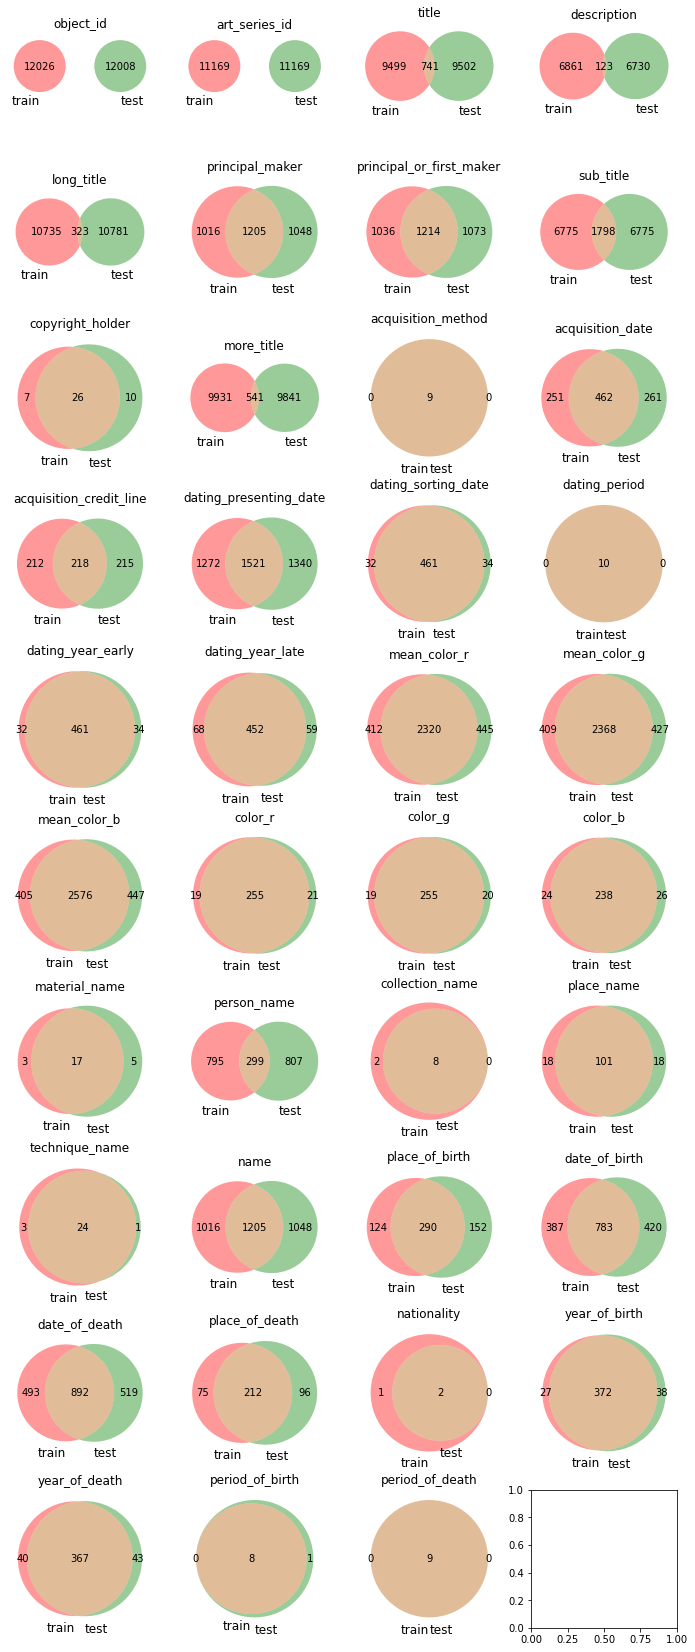

In [57]:
cols = train_df.drop(columns=['likes']).columns

n_figs = len(cols)
n_cols = 4
n_rows = n_figs // n_cols + 1

fix, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for col, ax in zip(cols, axes.ravel()):
    ax.set_title(f'{col}')
    venn2(subsets=[set(train_df[col].values), 
                   set(test_df[col].values)], 
          set_labels=['train', 'test'], 
          ax=ax)

In [108]:
process_blocks = [
    WrapperBlock(create_numerical_features),
    
    *[stringLengthBlock(col) for col in ['title', 'long_title', 'sub_title', 'more_title']],
    
    *[AggregationBlock(table_name) for table_name in ['material', 'historical_person']],
    
    *[CountEncoding(col, whole_df) for col in ['acquisition_method', 'title', 'dating_period',
                                               'principal_maker', 'copyright_holder', 'acquisition_method', 
                                               'collection_name', 'place_name', 'technique_name']],
    
    *[TargetEncoding(col, 'likes') for col in ['dating_period', 'acquisition_method', 
                                               'collection_name', 'technique_name', 'nationality', 
                                               'period_of_birth', 'period_of_death']],
    
    *[TfidfBlock(col) for col in ['long_title', 'description']],
    SizeExtractionBlock(),
#     OneHotEncoding(col='acquisition_method', threshold=100),
#     OneHotEncoding(col='principal_maker', threshold=200)
]

In [109]:
def get_function(block, is_train):
  s = mapping = {
      True: 'fit',
      False: 'transform'
  }.get(is_train)
  return getattr(block, s)

def to_features(input_df, blocks, is_train=False):
    output_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), block
        output_df = pd.concat([output_df, _df], axis=1)

    return output_df

In [110]:
train_feat_df = to_features(train_df, process_blocks, is_train=True)
test_feat_df = to_features(test_df, process_blocks)

 23%|██████████████████████▌                                                                           | 6/26 [00:00<00:00, 54.47it/s]

create fit 0.010[s]
create fit 0.005[s]
create fit 0.005[s]
create fit 0.005[s]
create fit 0.006[s]
create fit 0.060[s]
create fit 0.032[s]
create fit 0.006[s]
create fit 0.010[s]
create fit 0.003[s]
create fit 0.006[s]
create fit 0.005[s]


 85%|██████████████████████████████████████████████████████████████████████████████████               | 22/26 [00:00<00:00, 73.53it/s]

create fit 0.006[s]
create fit 0.006[s]
create fit 0.006[s]
create fit 0.005[s]
create fit 0.005[s]
create fit 0.005[s]
create fit 0.004[s]
create fit 0.006[s]
create fit 0.005[s]
create fit 0.005[s]
create fit 0.007[s]


c:\users\res12\appdata\local\pypoetry\cache\virtualenvs\python-6yvu1pyu-py3.9\lib\site-packages\texthero\preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
c:\users\res12\appdata\local\pypoetry\cache\virtualenvs\python-6yvu1pyu-py3.9\lib\site-packages\texthero\preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


create fit 2.144[s]
create fit 3.906[s]


 38%|█████████████████████████████████████▎                                                           | 10/26 [00:00<00:00, 94.28it/s]

create fit 0.409[s]
create transform 0.011[s]
create transform 0.007[s]
create transform 0.005[s]
create transform 0.005[s]
create transform 0.007[s]
create transform 0.011[s]
create transform 0.008[s]
create transform 0.004[s]
create transform 0.011[s]
create transform 0.002[s]
create transform 0.006[s]
create transform 0.006[s]
create transform 0.005[s]
create transform 0.005[s]
create transform 0.006[s]
create transform 0.005[s]
create transform 0.003[s]


 77%|██████████████████████████████████████████████████████████████████████████▌                      | 20/26 [00:00<00:00, 94.18it/s]

create transform 0.004[s]
create transform 0.005[s]
create transform 0.004[s]
create transform 0.005[s]
create transform 0.003[s]
create transform 0.005[s]
create transform 0.985[s]
create transform 2.174[s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  6.55it/s]

create transform 0.513[s]


os.makedirs(output_dir() / "profile", exist_ok=True)

feature_report = ProfileReport(train_feat_df)
feature_report.to_file(os.path.join(output_dir() / 'profile/train_feat_report.html'))

## Train Model

### LGBM

In [111]:
def fit_lgbm(X, y, params:dict=None, fit_params:dict=None, cv:list=None):
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True).split(X)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float64)
    
    y_d = np.log1p(y)
    
    for i, (train_idx, valid_idx) in enumerate(cv):
        X_train, y_train = X[train_idx], y_d[train_idx]
        X_valid, y_valid = X[valid_idx], y_d[valid_idx]
        
        model = LGBMRegressor(**params)
        with timer(prefix=f"fit fold={i+1}\t", suffix="\n"):
            model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_valid, y_valid)],
                        **fit_params)
        
        fold_pred_d = model.predict(X_valid)
        fold_pred = np.expm1(fold_pred_d)
        fold_pred = np.where(fold_pred < 0 , 0, fold_pred)
        oof_pred[valid_idx] = fold_pred
        
        models.append(model)
        
        fold_score = np.sqrt(MSE(y_valid, fold_pred_d))
                                    
        print(f"fold {i+1} RMSLE: {fold_score:.2f}")
        print("="*40 + "\n")
        
    oof_score = np.sqrt(MSLE(y, oof_pred))
                                    
    print(f"FINISHED \ whole score: {oof_score:.2f}")
    print("\n" + "="*40 + "\n")
    return models, oof_pred

In [113]:
SEED = 310

LGBM_PARAMS = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .01,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
#     'max_depth': 5, 
    'num_leaves': 128,

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 50_000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .7, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 5,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': SEED
}

LGBM_FIT_PARAMS = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 500,
    'verbose': 500,
}

In [114]:
y = train_df['likes'].values

fold = GroupKFold(n_splits=20)
cv = fold.split(train_feat_df, y, groups=train_df['art_series_id'])

In [115]:
models, oof_pred = fit_lgbm(X=train_feat_df.values, 
                            y=y,
                            cv=cv, 
                            params=LGBM_PARAMS, 
                            fit_params=LGBM_FIT_PARAMS)

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.571366	valid_1's rmse: 1.04001
[1000]	training's rmse: 0.379539	valid_1's rmse: 1.02922
[1500]	training's rmse: 0.268815	valid_1's rmse: 1.02632
[2000]	training's rmse: 0.195301	valid_1's rmse: 1.02522
[2500]	training's rmse: 0.145786	valid_1's rmse: 1.02463
Early stopping, best iteration is:
[2406]	training's rmse: 0.153587	valid_1's rmse: 1.02423
fit fold=1	63.999[s]

fold 1 RMSLE: 1.02

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.572559	valid_1's rmse: 1.00542
[1000]	training's rmse: 0.37781	valid_1's rmse: 1.00016
[1500]	training's rmse: 0.268411	valid_1's rmse: 0.999965
Early stopping, best iteration is:
[1291]	training's rmse: 0.308309	valid_1's rmse: 0.99903
fit fold=2	46.879[s]

fold 2 RMSLE: 1.00

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.570471	valid_1's rmse: 1.06304
[1000]	training's rmse: 0.377848	val

## Feature Importance

In [116]:
def visualize_importance(models, train_feat_df, importance_type='gain'):
    feature_importance_df = pd.DataFrame()

    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = train_feat_df.columns
        _df['fold'] = i + 1

    feature_importance_df = pd.concat([feature_importance_df,
                                       _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  y='column', 
                  x='feature_importance', 
                  order=order, ax=ax, 
                  palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True)
    fig.tight_layout()
    return fig, ax

In [117]:
train_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12026 entries, 0 to 12025
Columns: 147 entries, dating_period to size_d
dtypes: float64(137), int64(6), object(4)
memory usage: 13.6+ MB


(<Figure size 576x900 with 1 Axes>,
 <AxesSubplot:xlabel='feature_importance', ylabel='column'>)

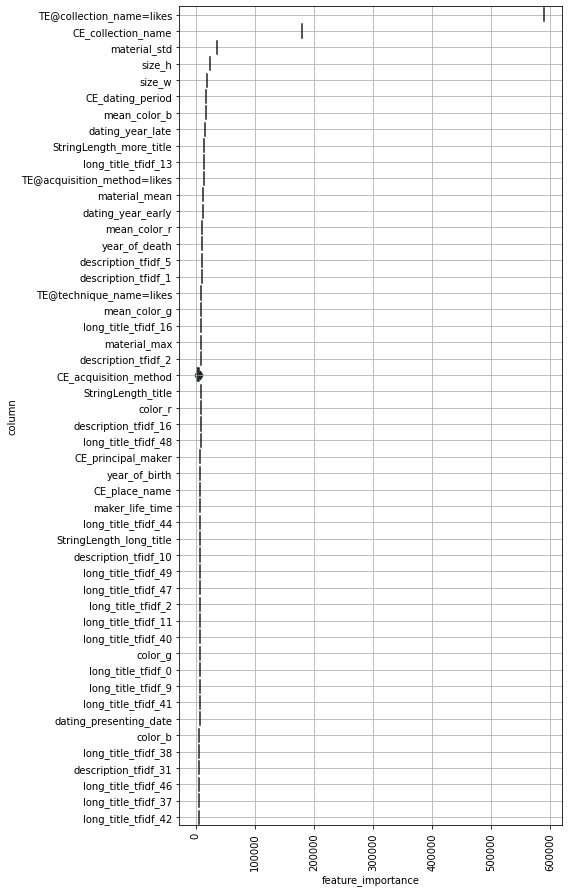

In [118]:
visualize_importance(models, train_feat_df)

## Inference

In [119]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [120]:
os.makedirs(output_dir() / 'csv', exist_ok=True)

pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)

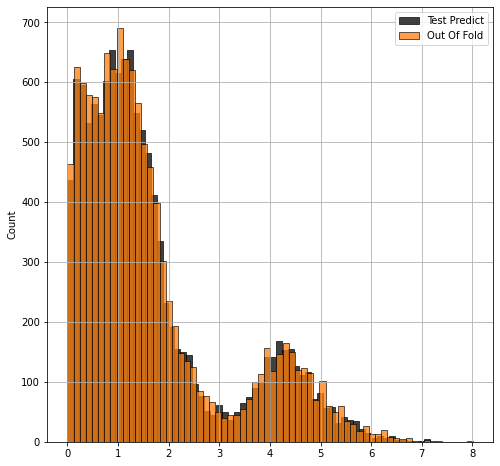

In [121]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(np.log1p(oof_pred), label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [122]:
numbering = '0015'

sub_df = pd.DataFrame({ 'likes': pred })

assert len(sub_df) == 12_008

sub_df.to_csv(os.path.join(output_dir() / f'csv/{numbering}__submission.csv'), index=False)